<h1>Model: Female Anger vs. Others</h1>

In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

In [2]:
import keras
import pandas as pd
import tensorflow as tf

import numpy as np
# from keras.models import Sequential, Model
# from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D
from keras.utils import np_utils

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D, GlobalAveragePooling2D, Input,AveragePooling2D, BatchNormalization, LeakyReLU

# from keras.applications import MobileNet
# from keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2, InceptionV3
from tensorflow.keras.optimizers import Adam

from matplotlib import pyplot as plt
import os
from sklearn.model_selection import train_test_split

import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.model_selection import KFold

from collections import defaultdict


<h2>Data Loading and Preparation</h2>

In [3]:
def getEmotionCode(x):
    part = x.split('_')
    if part[1] == 'ANG':
        return 1
    else:
        return 0

def getEmotion(x):
    if x == 1:
        return 'ANG'
    else:
        return 'OTH'

In [4]:
X_all = np.load('../data/Ess_Mel_1_5_NMP/Ess_Mel_1_5_NMP_X.npy', allow_pickle= True)
Y_all = np.load('../data/Ess_Mel_1_5_NMP/Ess_Mel_1_5_NMP_Y.npy', allow_pickle= True)

In [5]:
X_all = X_all.astype('float32')

In [6]:
for i in range(Y_all.shape[0]):
    Y_all[i] = getEmotionCode(Y_all[i])


In [8]:
for i in range(X_all.shape[0]):
    X_all[i] = (X_all[i] - X_all[i].mean()) / X_all[i].std()
    
#for i in range(X_all.shape[0]):
#    X_all[i] = (X_all[i] - X_all[i].min()) / (X_all[i].max() -  X_all[i].min())

In [9]:
Y_all = np_utils.to_categorical(Y_all, num_classes=2) 

In [10]:
# train /test= 80/20% split
# stratified
X_train, X_test, Y_train, Y_test = train_test_split(X_all, Y_all, test_size=0.2, random_state = 123, stratify=Y_all)



<h2>Model Building</h2>

In [11]:
def build_current_model():
    inp = Input(shape=(128, 151,1))
    
    lay = Convolution2D(filters=128,kernel_size=(5,5),strides=(2,2),padding='same')(inp)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = MaxPooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.2)(lay)

    
    lay = Convolution2D(filters=256,kernel_size=(3,3),strides=(2,2),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)
    
    lay = Convolution2D(filters=256,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.3)(lay)
    
    lay = Convolution2D(filters=512,kernel_size=(3,3),strides=(1,1),padding='same')(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('relu')(lay)
    lay = AveragePooling2D(pool_size=(2,2),strides=2,padding='same')(lay)
    lay = Dropout(0.4)(lay)
    
    lay = Flatten()(lay)
    
    lay = Dense(256)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('elu')(lay)
    lay = Dropout(0.3)(lay)
    
    lay = Dense(64)(lay)
    lay = BatchNormalization()(lay)
    lay = Activation('elu')(lay)
    lay = Dropout(0.2)(lay)


    x_out = Dense(2, name='output', activation='softmax')(lay)
    
    model = Model(inputs=inp, outputs=x_out)
    model.compile(optimizer=Adam(lr=0.001), 
                  loss='categorical_crossentropy', 
                  metrics = ['accuracy'])
    return model


In [12]:
model = build_current_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 151, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 76, 128)       3328      
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 76, 128)       512       
_________________________________________________________________
activation (Activation)      (None, 64, 76, 128)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 38, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 32, 38, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 19, 256)       295168

In [ ]:
#tf.keras.utils.plot_model(model, "Model-Ref7Var.png", show_shapes=True)

In [13]:
history = model.fit(X_train, Y_train, 
              epochs = 50, 
              validation_split=0.1, 
              verbose=1, 
              batch_size = 8)

history_info = history.history

Epoch 1/50
263/263 [==============================] - 2s 9ms/step - loss: 0.5128 - accuracy: 0.7631 - val_loss: 0.4018 - val_accuracy: 0.8632
Epoch 2/50
263/263 [==============================] - 2s 8ms/step - loss: 0.4022 - accuracy: 0.8541 - val_loss: 0.5304 - val_accuracy: 0.7650
Epoch 3/50
263/263 [==============================] - 2s 8ms/step - loss: 0.3857 - accuracy: 0.8589 - val_loss: 0.5779 - val_accuracy: 0.6581
Epoch 4/50
263/263 [==============================] - 2s 9ms/step - loss: 0.3642 - accuracy: 0.8656 - val_loss: 0.7668 - val_accuracy: 0.5342
Epoch 5/50
263/263 [==============================] - 3s 10ms/step - loss: 0.3469 - accuracy: 0.8713 - val_loss: 0.3259 - val_accuracy: 0.8590
Epoch 6/50
263/263 [==============================] - 2s 8ms/step - loss: 0.3471 - accuracy: 0.8670 - val_loss: 0.3348 - val_accuracy: 0.8803
Epoch 7/50
263/263 [==============================] - 3s 10ms/step - loss: 0.3331 - accuracy: 0.8718 - val_loss: 0.3752 - val_accuracy: 0.8632
Epoc

<h2>Evaluation (Basic)</h2>

In [20]:
def generate_actual_predicted(Y_pred, X_test, Y_test): 
    predicted = list()
    for i in range(len(Y_pred)):
        predicted.append(np.argmax(Y_pred[i]))
        
    actual = list()
    for i in range(len(Y_test)):
        actual.append(np.argmax(Y_test[i]))
        
    return actual, predicted

Y_pred = model.predict(X_test)
actual, predicted = generate_actual_predicted(Y_pred, X_test, Y_test)
actual_labeled = list()
predict_labeled = list()
for x,y in zip(actual,predicted):
    actual_labeled.append(getEmotion(x))
    predict_labeled.append(getEmotion(y))
labels = ['ANG','OTH']


In [21]:
## Precision, Recall, F1, Support
from sklearn.metrics import classification_report
print(classification_report(actual_labeled, predict_labeled,labels=labels))

              precision    recall  f1-score   support

         ANG       0.57      0.66      0.61        77
         OTH       0.95      0.92      0.94       506

    accuracy                           0.89       583
   macro avg       0.76      0.79      0.78       583
weighted avg       0.90      0.89      0.89       583



<AxesSubplot:ylabel='accuracy'>

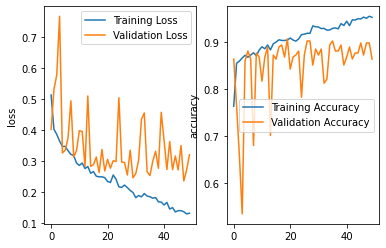

In [22]:
## Loss and accuracy history
_, axs = plt.subplots(ncols=2)
df_history_info = pd.DataFrame(history_info) 


sns.lineplot(data=df_history_info['loss'],ax=axs[0], label='Training Loss', legend='brief')
sns.lineplot(data=df_history_info['val_loss'],ax=axs[0], label='Validation Loss', legend='brief')

sns.lineplot(data=df_history_info['accuracy'],ax=axs[1], label='Training Accuracy', legend='brief')
sns.lineplot(data=df_history_info['val_accuracy'],ax=axs[1], label='Validation Accuracy', legend='brief')

[[ 51  26]
 [ 38 468]]


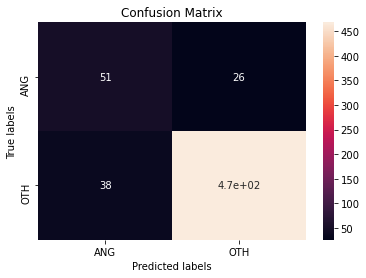

In [23]:

##Confusion Matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(actual_labeled,predict_labeled,labels=labels)
print(cm)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(labels); ax.yaxis.set_ticklabels(labels);

In [24]:
## Test accuracy
from sklearn.metrics import accuracy_score
print('accuracy', accuracy_score(actual, predicted))


accuracy 0.8902229845626072


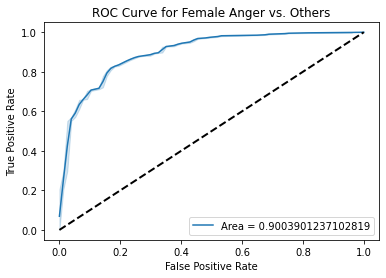

In [25]:
## ROC Curves
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from scipy import interp

### The following curves are generated s.t each point is a model from differing thresholds

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='False Positive Rate',ylabel='True Positive Rate', title='ROC Curve for Female Anger vs. Others')


fpr, tpr, _ = roc_curve(Y_test[:,0], Y_pred[:,0])
auc_val = auc(fpr, tpr)
sns.lineplot(x=fpr,y=tpr,ax=axs, label='Area = ' + str(auc_val) + '', legend='brief')


plt.plot([0, 1], [0, 1], 'k--', lw=2)

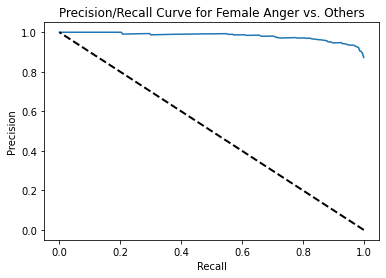

In [26]:
## Precision/Recall Curves per class
### The following curves are generated s.t each point is a model from differing thresholds
from sklearn.metrics import precision_recall_curve

_, axs = plt.subplots(ncols=1)
axs.set(xlabel='Recall',ylabel='Precision', title='Precision/Recall Curve for Female Anger vs. Others')

prec, rec, _ = precision_recall_curve(Y_test[:,0], Y_pred[:,0])
sns.lineplot(x=rec,y=prec,ax=axs)

# Diagonal line for comparison
plt.plot([1, 0], [0, 1], 'k--', lw=2)

<h2>Storing/Loading history and model to file</h2>

In [28]:
import tensorflowjs as tfjs

tfjs_target_dir = r"tfjs_models/essentia_v1"
tfjs.converters.save_keras_model(model, tfjs_target_dir)
